In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.impute import KNNImputer, SimpleImputer
from fancyimpute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from scipy.stats import ks_2samp
from scipy.special import kl_div
import warnings
from sklearn.exceptions import ConvergenceWarning
import umap.umap_ as umap

warnings.filterwarnings("ignore", category=ConvergenceWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

D:\4_course\VKR\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('raw/RDBA_BEKHTEREV2.xlsx')
df.head()

,Id,КОД3 основной,Пол,Образование,Трудовая деятельность,Семейное положение,Проживание,Жилищные условия,Инвалидность,Отягощ. Наследственность,Инфекционные болезни НС,Злоупотребление психоактивными вещ-вами,Интоксикации,ЧМТ,Гипертония,Церебрально-сосудистые нарушения,Эндокринные заболевания,"Аллергические заб., в т.ч. астма",операции,"Кол-во декомпенсаций (фаз, обострений)",Совпадение начала заболевания,Уровень выраженности псих. Расстр.,Левша,Возраст,Возраст дебюта расстройств (полных лет),Длительность заболевания (месяцев),Цитогенетика,Иммунология,Альбумин,Холестерин,Общий белок,Глюкоза,ЛПВП,ЛПНП,Триглицериды,С-реактивный белок,К.а,Пролактин,Кортизол,Дегидроэпиандростерона-сульфат,Корт/ДГЭА,Эстрадиол,Тестостерон своб,Инсулин,ТТГ,Т3 своб.,Т4 своб.,Апо А,Апо В,АпоЕ,АпоВ/А,Цистатин С 1,Цистатин С рук,Hb,Эритроциты,Тромбоциты,Лейкоциты,СОЭ,Ретикулоциты,СОД164-240 E/ml,СОД E/l 1102-16012 U/g Hb,ГР в эритроцитах Е/г Hb,ГР в плазме E/л,ГП в эритроцитах Е/л,каталаза,МДА мкмоль/л=нмоль/мл,Тиоловый статус,МПО 1 нг/мл,Липидные гидроперекиси ЛГ,ДК эр,ТК эр,глу-S-транс пл,глу-S-транс/ Hb,кат.пл пл.,кат.пл Б.,кат.пл с Азидол,кат.пл Б с Азидол,кат эр,кат эр Hb,глу вост кр.,глу ок кр,глу вост эр,глу ок эр,ОМБ Sp/мл пл,ОМБ Sp/г Б,ОМБ МКО/мл пл,ОМБ МКО/г Б,ДК Пл,ГК пл,Д-димер,EPA,DHA,ALA,LA,ARA,ERUC,MMSE,Тест часов,Батарея лобной дисфункции,ИТТ Общ. СТ,итт ЭД ст,итт АСТ ст,итт ФОБ ст,итт ОП ст,итт СЗ ст,ИТТ Общ. ЛТ,итт ЭД лт,итт АСТ лт,итт ФОБ лт,итт ОП лт,итт СЗ лт,BDI (Бек),В I,В II,В III,В IV,В V,В Va пр,В Vb обр,В VI,В VII,В VIIa легк,В VIIb трудн,В ЭИПП,Общий показатель,Внимание,Попытки,Память,Беглость,Язык,ЗПО,T1,T2,T3,Ош_1,Ош_2,Пропущено строк,Ош_3,КИ,КВ
0,1,1,2,6.0,6.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,NaN,3.0,1.0,3.0,NaN,83,63.0,240.0,51.0,NaN,40.00,6.05,72.30,5.35,1.82,2.91,0.92,13.85,2.33,183.0,1641.0,0.88,NaN,107.6,0.34,7.6,1.18,2.63,12.97,220.80,104.70,7.21,0.47,1.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0,36.4,0.25,1083.94,0.31,23.11,0.04,3.08,3.10,NaN,18.90,0.29,13.11,7.84,4.20,57.01,37.6,510.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,10.0,14.0,2.0,1.0,5.0,1.0,2.0,5.0,4.0,4.0,5.0,1.0,3.0,7.0,5.0,5.0,5.0,3.0,8.0,11.0,6.0,5.0,4.0,13.0,9.0,4.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,4.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,NaN,1.0,2.0,3.0,NaN,69,69.0,3.0,55.0,NaN,45.20,5.90,73.00,5.35,1.15,4.45,1.36,9.96,NaN,NaN,564.0,3.60,NaN,244.6,13.79,23.4,1.40,4.50,18.10,181.67,124.90,4.12,0.70,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237.4,40.6,0.41,1416.35,0.24,17.72,0.03,2.31,1.97,6.84,9.59,NaN,NaN,NaN,3.66,49.92,33.6,458.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,8.0,15.0,4.0,3.0,2.0,4.0,4.0,8.0,8.0,9.0,8.0,6.0,6.0,7.0,24.0,6.0,5.0,4.0,7.0,10.0,6.0,4.0,2.0,10.0,7.0,3.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,2,6.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,NaN,1.0,2.0,2.0,NaN,64,63.0,7.0,45.0,NaN,43.98,6.96,71.98,3.90,2.09,3.68,1.23,0.20,NaN,36.0,516.0,1.80,NaN,NaN,0.87,12.0,4.20,2.40,21.70,247.89,112.57,5.23,0.44,0.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.2,39.5,0.27,1067.26,0.22,16.18,0.04,3.08,1.48,5.92,6.21,NaN,NaN,NaN,3.18,43.29,29.8,405.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,10.0,18.0,4.0,1.0,5.0,1.0,6.0,6.0,7.0,7.0,6.0,1.0,9.0,8.0,19.0,6.0,5.0,6.0,11.0,11.0,6.0,5.0,11.0,21.0,9.0,12.0,143.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,2,4.0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,56,54.0,24.0,80.0,NaN,42.75,5.88,68.94,4.83,1.74,2.95,0.78,0.06,2.20,95.0,393.0,3.42,NaN,157.4,0.80,NaN,1.45,5.17,19.20,NaN,NaN,6.14,NaN,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.2,30.8,NaN,NaN,0.27,18.49,0.03,2.31,1.62,5.49,10.65,4.07,NaN,NaN,3.78,54.85,31.6,458.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,10.0,15.0,5.0,3.0,5.0,4.0,9.0,5.0

In [3]:
df.shape

(254, 140)

In [4]:
df.dtypes

Id                                           int64
КОД3 основной                                int64
Пол                                          int64
Образование                                float64
Трудовая деятельность                      float64
Семейное положение                         float64
Проживание                                 float64
Жилищные условия                           float64
Инвалидность                               float64
Отягощ. Наследственность                   float64
Инфекционные болезни НС                    float64
Злоупотребление психоактивными вещ-вами    float64
Интоксикации                               float64
ЧМТ                                        float64
Гипертония                                 float64
Церебрально-сосудистые нарушения           float64
Эндокринные заболевания                    float64
Аллергические заб., в т.ч. астма           float64
операции                                   float64
Кол-во декомпенсаций (фаз, обос

In [5]:
def detect_column_type(series):
    non_null = series.dropna()
    unique_count = non_null.nunique()
    
    if np.all(non_null.apply(lambda x: float(x).is_integer())):
        return 'categorical' if unique_count <= 10 else 'int'
    
    return 'float'
    
column_types = {col: detect_column_type(df[col]) for col in df.columns}
column_types

{'Id': 'int',
 'КОД3 основной': 'categorical',
 'Пол': 'categorical',
 'Образование': 'categorical',
 'Трудовая деятельность': 'categorical',
 'Семейное положение': 'categorical',
 'Проживание': 'categorical',
 'Жилищные условия': 'categorical',
 'Инвалидность': 'categorical',
 'Отягощ. Наследственность': 'categorical',
 'Инфекционные болезни НС': 'categorical',
 'Злоупотребление психоактивными вещ-вами': 'categorical',
 'Интоксикации': 'categorical',
 'ЧМТ': 'categorical',
 'Гипертония': 'categorical',
 'Церебрально-сосудистые нарушения': 'categorical',
 'Эндокринные заболевания': 'float',
 'Аллергические заб., в т.ч. астма': 'categorical',
 'операции': 'categorical',
 'Кол-во декомпенсаций (фаз, обострений)': 'categorical',
 'Совпадение начала заболевания': 'categorical',
 'Уровень выраженности псих. Расстр.': 'categorical',
 'Левша': 'categorical',
 'Возраст': 'int',
 'Возраст дебюта расстройств (полных лет)': 'int',
 'Длительность заболевания (месяцев)': 'int',
 'Цитогенетика': 'in

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,254.0,127.500000,73.467680,1.000000,64.25000,127.5000,190.750000,254.00
КОД3 основной,254.0,2.944882,1.638505,1.000000,2.00000,3.0000,4.000000,6.00
Пол,254.0,1.779528,0.415384,1.000000,2.00000,2.0000,2.000000,2.00
Образование,239.0,5.054393,1.247338,2.000000,4.00000,6.0000,6.000000,7.00
Трудовая деятельность,240.0,5.000000,1.879197,1.000000,5.00000,6.0000,6.000000,8.00
Семейное положение,239.0,2.656904,1.020517,1.000000,2.00000,2.0000,4.000000,5.00
Проживание,239.0,1.958159,0.839121,1.000000,1.00000,2.0000,3.000000,4.00
Жилищные условия,239.0,1.071130,0.341713,1.000000,1.00000,1.0000,1.000000,4.00
Инвалидность,239.0,1.677824,0.944227,1.000000,1.00000,1.0000,3.000000,4.00
Отягощ. Наследственность,228.0,1.206140,0.405423,1.000000,1.00000,1.0000,1.000000,2.00


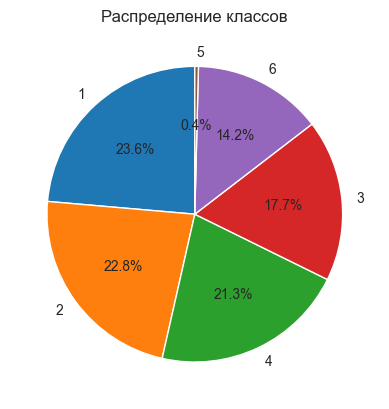

In [7]:
target_column = 'КОД3 основной'
class_distribution = df[target_column].value_counts()
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Распределение классов')
plt.ylabel('')
plt.show()

In [8]:
missing_values = (df.isnull().sum() / len(df)) * 100
total_missing = missing_values.sum()
missing_values_df = pd.DataFrame({'missing_percentage': missing_values})
missing_values_df

,missing_percentage
Id,0.000000
КОД3 основной,0.000000
Пол,0.000000
Образование,5.905512
Трудовая деятельность,5.511811
Семейное положение,5.905512
Проживание,5.905512
Жилищные условия,5.905512
Инвалидность,5.905512
Отягощ. Наследственность,10.236220


In [9]:
missing_percentage_rows = (df.isnull().sum(axis=1) / len(df.columns)) * 100
missing_percentage_rows_df = pd.DataFrame({'missing_percentage': missing_percentage_rows})
missing_percentage_rows_df

,missing_percentage
0,33.571429
1,36.428571
2,36.428571
3,38.571429
4,35.714286
5,35.000000
6,52.857143
7,55.000000
8,36.428571
9,33.571429


In [10]:
df_cleaned = df.dropna(thresh=len(df.columns) * 0.155)
df_cleaned = df_cleaned.dropna(thresh=len(df_cleaned) * 0.1, axis=1)
types = {col: detect_column_type(df_cleaned[col]) for col in df_cleaned.columns}
int_cols = [col for col, t in types.items() if t == 'int']
cat_cols = [col for col, t in types.items() if t == 'categorical' and col != target_column]
df_cleaned.shape

(253, 122)

In [11]:
def kl_divergence(p, q):
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    return np.sum(kl_div(p, q))

def compute_distance_and_significance(df_cleaned, df_imputed, alpha=0.05):
    distances = {}
    significant_count = 0
    total_columns = 0
    
    for col in df_cleaned.columns:
        if df_cleaned[col].isnull().sum() == 0:
            continue
        
        valid_values = df_cleaned[col].dropna()
        filled_values = df_imputed[col]
        
        # KL Divergence
        hist_valid, bin_edges = np.histogram(valid_values, bins=20, density=True)
        hist_valid /= hist_valid.sum()
        hist_filled, _ = np.histogram(filled_values, bins=bin_edges, density=True)
        hist_filled /= hist_filled.sum()
        distances[col] = kl_divergence(hist_valid, hist_filled)
        
        # KS test
        stat, p_value = ks_2samp(valid_values, filled_values)
        if p_value < alpha:
            significant_count += 1
        
        total_columns += 1

    avg_kl_div = np.mean(list(distances.values())) if distances else 0
    percent_significant = (significant_count / total_columns * 100) if total_columns > 0 else 0
    
    return avg_kl_div, significant_count, percent_significant

def evaluate_methods(df_cleaned, all_imputed_dfs, alpha=0.05):
    results = []
    
    for method_name, df_imputed in all_imputed_dfs.items():
        avg_kl_div, significant_count, percent_significant = compute_distance_and_significance(df_cleaned, df_imputed, alpha)
        results.append([method_name, avg_kl_div, significant_count, percent_significant])
    
    results_df = pd.DataFrame(results, columns=['Method', 'Avg_KL_Divergence', 'Significant_Count', 'Percentage_Significant'])
    results_df.sort_values(by=['Percentage_Significant', 'Avg_KL_Divergence'], ascending=[True, True], inplace=True)
    return results_df

In [12]:
class AutoModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = None

    def fit(self, X, y):
        if pd.Series(y).nunique() <= 10 and pd.Series(y).dropna().apply(float.is_integer).all():
            self.model = LogisticRegression(max_iter=10000, solver='sag', n_jobs=-1)
        else:
            self.model = BayesianRidge()
        self.model.fit(X, y)
        return self

    def predict(self, X):
        pred = self.model.predict(X)
        return pred.astype(float) if hasattr(self.model, 'predict_proba') else pred

def run_imputation_and_store(name, imputer, df_base, all_dfs, int_cols, cat_cols, scale=False):
    if scale:
        scaler = StandardScaler()
        df_base_scaled = pd.DataFrame(scaler.fit_transform(df_base), columns=df_base.columns)
    else:
        df_base_scaled = df_base

    df_imputed = pd.DataFrame(imputer.fit_transform(df_base_scaled), columns=df_base.columns)
    if scale:
        df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), columns=df_base.columns)

    df_imputed[int_cols] = df_imputed[int_cols].round().astype('Int64')
    df_imputed[cat_cols] = df_imputed[cat_cols].round().astype('Int64')
    all_dfs[name] = df_imputed

models = {
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_iter=100, max_depth=5, random_state=42)
}

imputers_to_run = [
    ('KNNImputer (default)', KNNImputer()),
    ('KNNImputer (w=dist)', KNNImputer(weights='distance')),
    ('KNNImputer (2 neigh)', KNNImputer(n_neighbors=2)),
    ('KNNImputer (2 neigh, w=dist)', KNNImputer(n_neighbors=2, weights='distance')),
    ('KNNImputer (3 neigh)', KNNImputer(n_neighbors=3)),
    ('KNNImputer (3 neigh, w=dist)', KNNImputer(n_neighbors=3, weights='distance')),
    ('IterativeImputer_BayesianRidge', IterativeImputer(estimator=BayesianRidge(), max_iter=100, random_state=42, verbose=1)),
    ('IterativeImputer_AutoModel', IterativeImputer(estimator=AutoModel(), max_iter=100, random_state=42, verbose=1))
]

all_imputed_dfs = {}

for name, imputer in imputers_to_run:
    print(name, 'not scaled')
    run_imputation_and_store(name, imputer, df_cleaned, all_imputed_dfs, int_cols, cat_cols, scale=False)
    print(name, 'scaled')
    run_imputation_and_store(name + " (scaled)", imputer, df_cleaned, all_imputed_dfs, int_cols, cat_cols, scale=True)

df_imputed_initial = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(df_cleaned), columns=df_cleaned.columns)
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_imputed_initial)
df_pca_back = pca.inverse_transform(df_pca)
df_imputed_z = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(df_pca_back), columns=df_cleaned.columns)
all_imputed_dfs["Z_algorithm"] = df_imputed_z

for model_name, model in models.items():
    imputer = IterativeImputer(estimator=model, max_iter=100, random_state=42, verbose=1)
    run_imputation_and_store(model_name, imputer, df_cleaned, all_imputed_dfs, int_cols, cat_cols, scale=False)
    run_imputation_and_store(model_name + " (scaled)", imputer, df_cleaned, all_imputed_dfs, int_cols, cat_cols, scale=True)

final_results_df = evaluate_methods(df_cleaned, all_imputed_dfs)
final_results_df

KNNImputer (default) not scaled
KNNImputer (default) scaled
KNNImputer (w=dist) not scaled
KNNImputer (w=dist) scaled
KNNImputer (2 neigh) not scaled
KNNImputer (2 neigh) scaled
KNNImputer (2 neigh, w=dist) not scaled
KNNImputer (2 neigh, w=dist) scaled
KNNImputer (3 neigh) not scaled
KNNImputer (3 neigh) scaled
KNNImputer (3 neigh, w=dist) not scaled
KNNImputer (3 neigh, w=dist) scaled
IterativeImputer_BayesianRidge not scaled
[IterativeImputer] Completing matrix with shape (253, 122)
[IterativeImputer] Change: 8498.979390931507, scaled tolerance: 5.184 
[IterativeImputer] Change: 3260.553351970569, scaled tolerance: 5.184 
[IterativeImputer] Change: 1522.7195352851318, scaled tolerance: 5.184 
[IterativeImputer] Change: 531.7192672102557, scaled tolerance: 5.184 
[IterativeImputer] Change: 440.8964473077232, scaled tolerance: 5.184 
[IterativeImputer] Change: 186.76185808223613, scaled tolerance: 5.184 
[IterativeImputer] Change: 158.5191263261906, scaled tolerance: 5.184 
[Iterative

,Method,Avg_KL_Divergence,Significant_Count,Percentage_Significant
7,"KNNImputer (2 neigh, w=dist) (scaled)",0.084841,2,1.694915
5,KNNImputer (2 neigh) (scaled),0.087440,3,2.542373
11,"KNNImputer (3 neigh, w=dist) (scaled)",0.098196,11,9.322034
9,KNNImputer (3 neigh) (scaled),0.099185,11,9.322034
8,KNNImputer (3 neigh),0.130965,19,16.101695
3,KNNImputer (w=dist) (scaled),0.125263,20,16.949153
1,KNNImputer (default) (scaled),0.125470,21,17.796610
6,"KNNImputer (2 neigh, w=dist)",0.132148,25,21.186441
4,KNNImputer (2 neigh),0.138592,25,21.186441
10,"KNNImputer (3 neigh, w=dist)",0.131204,26,22.033898


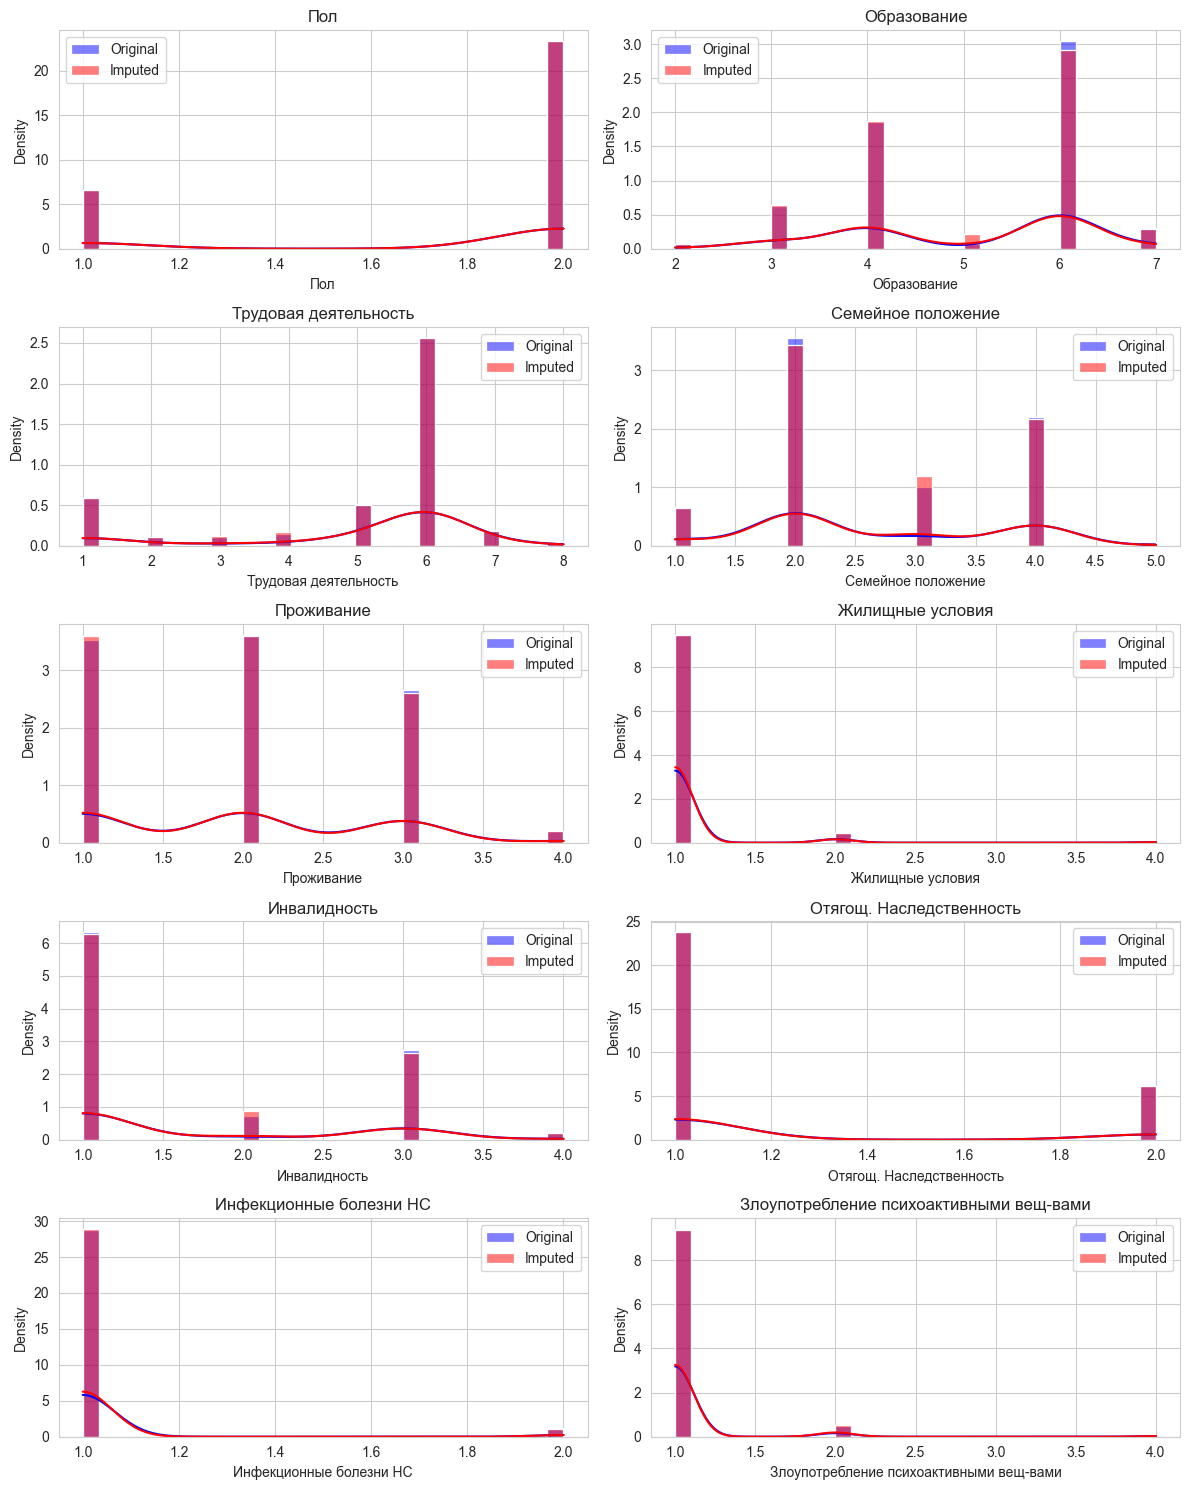

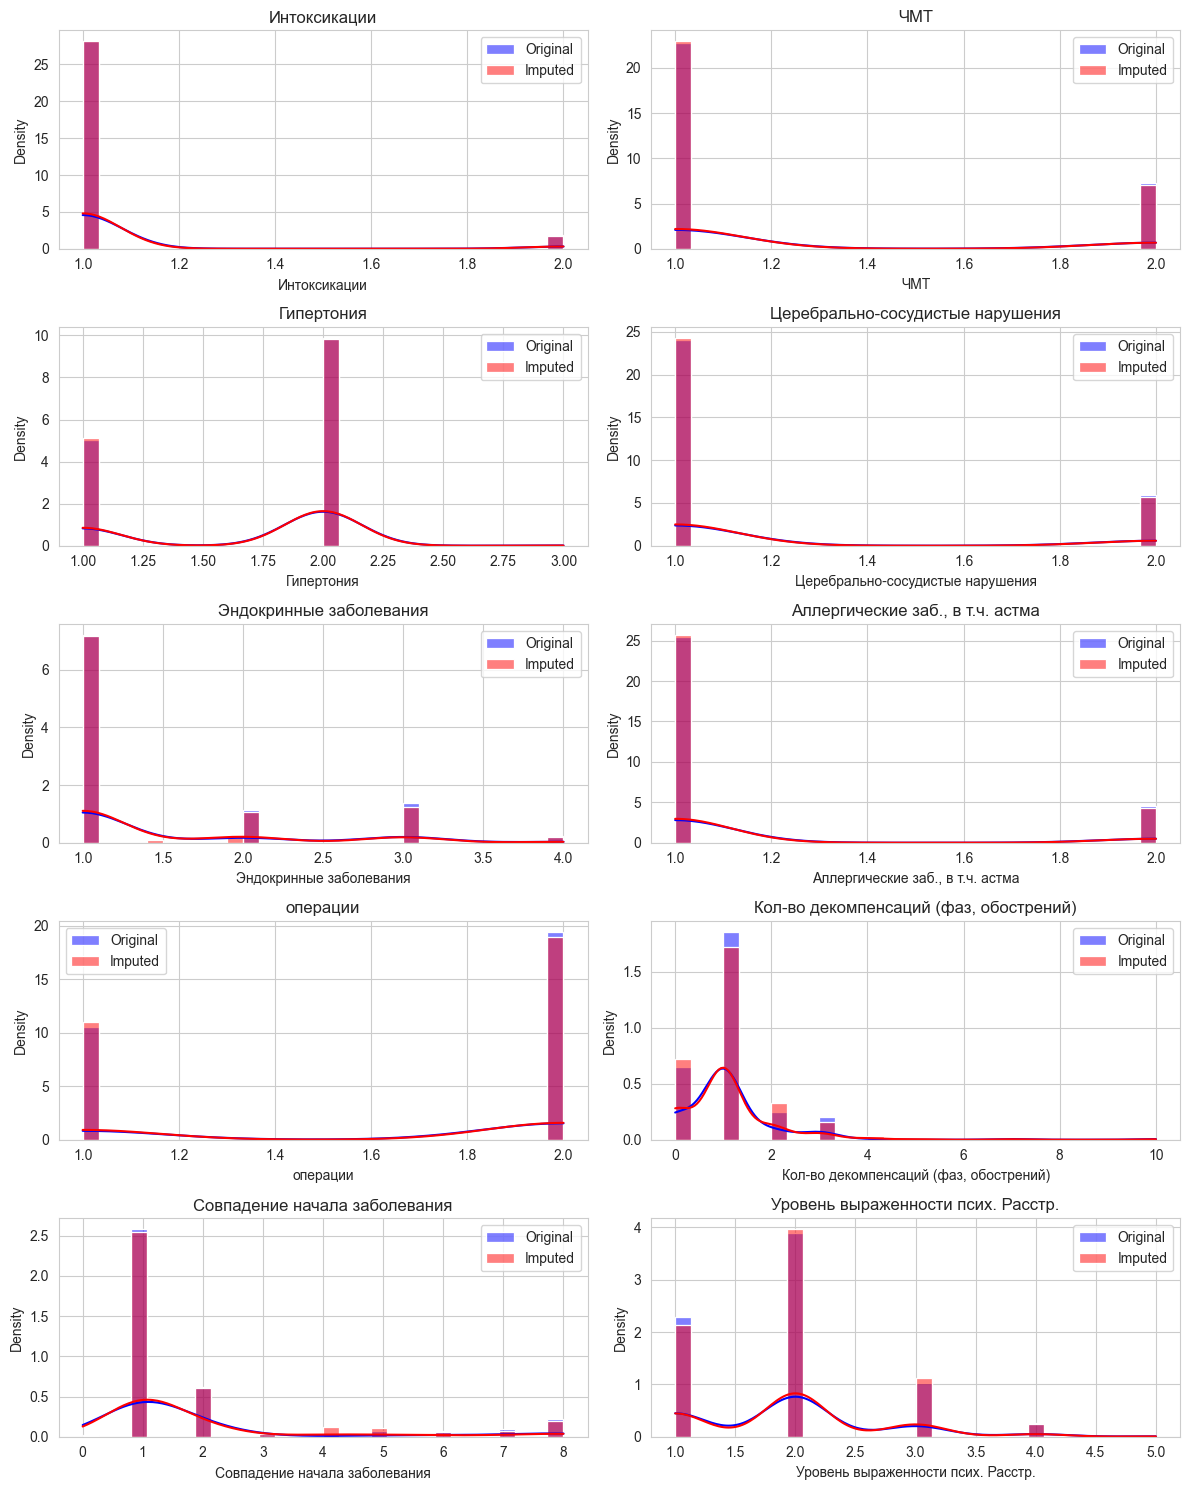

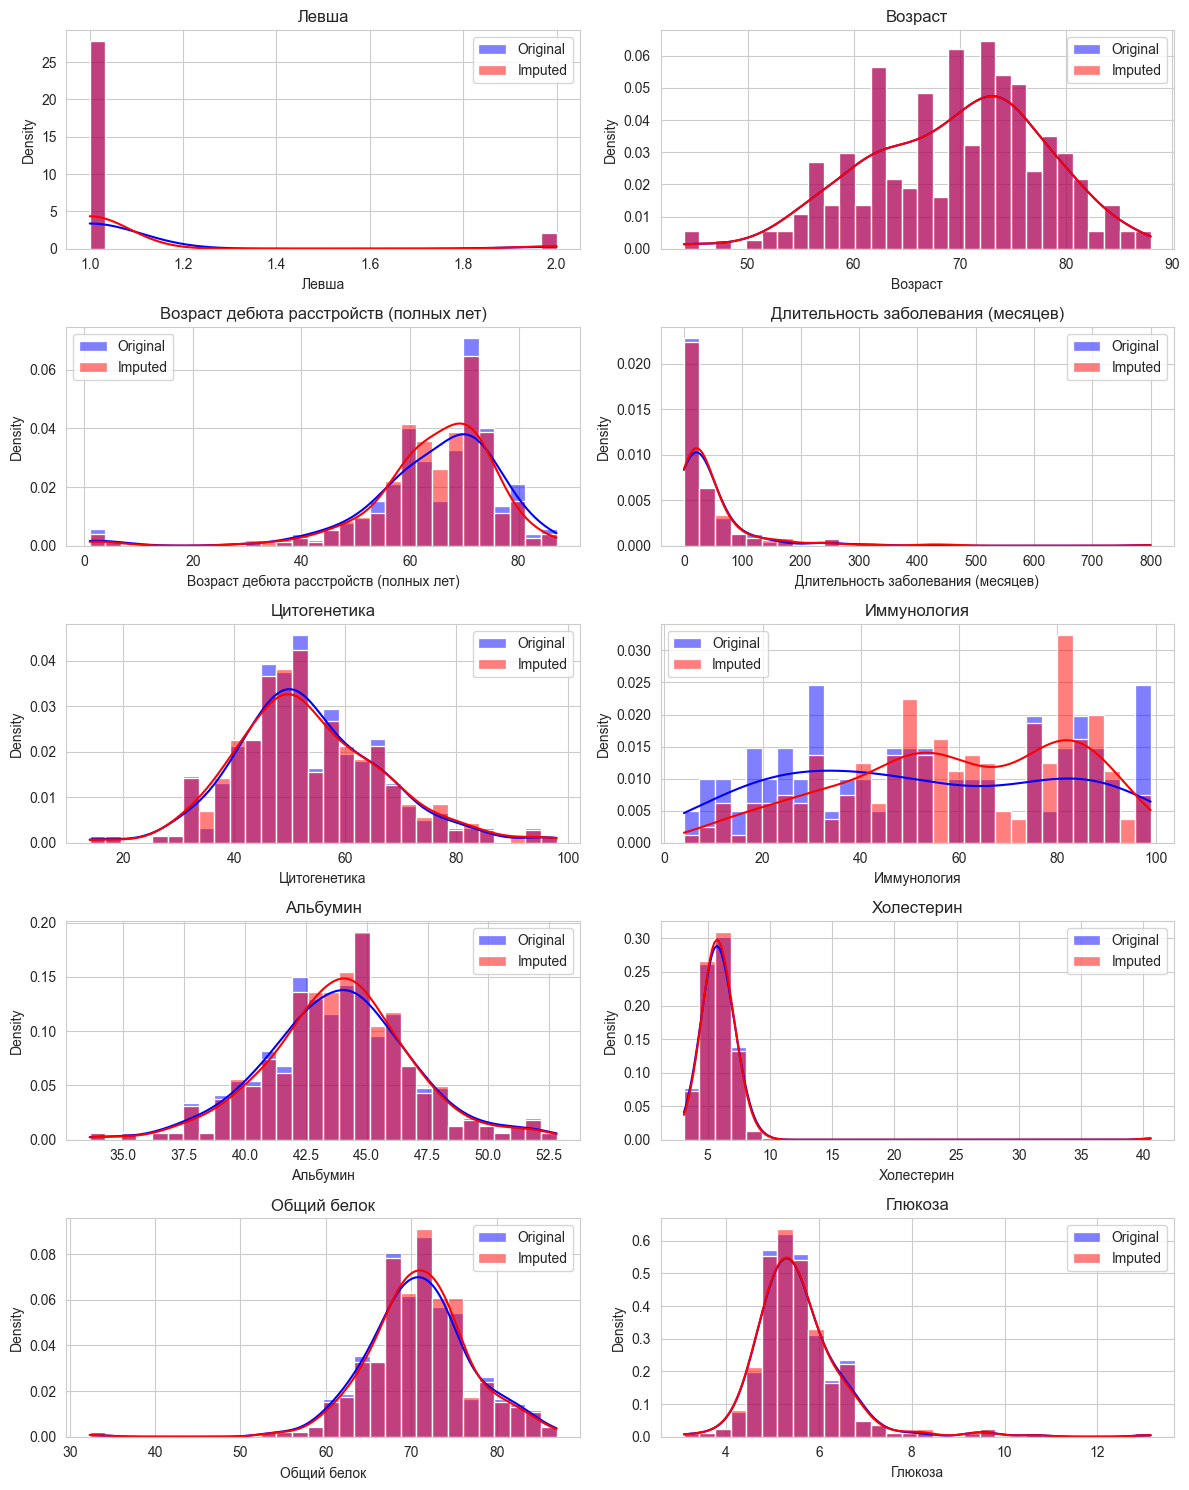

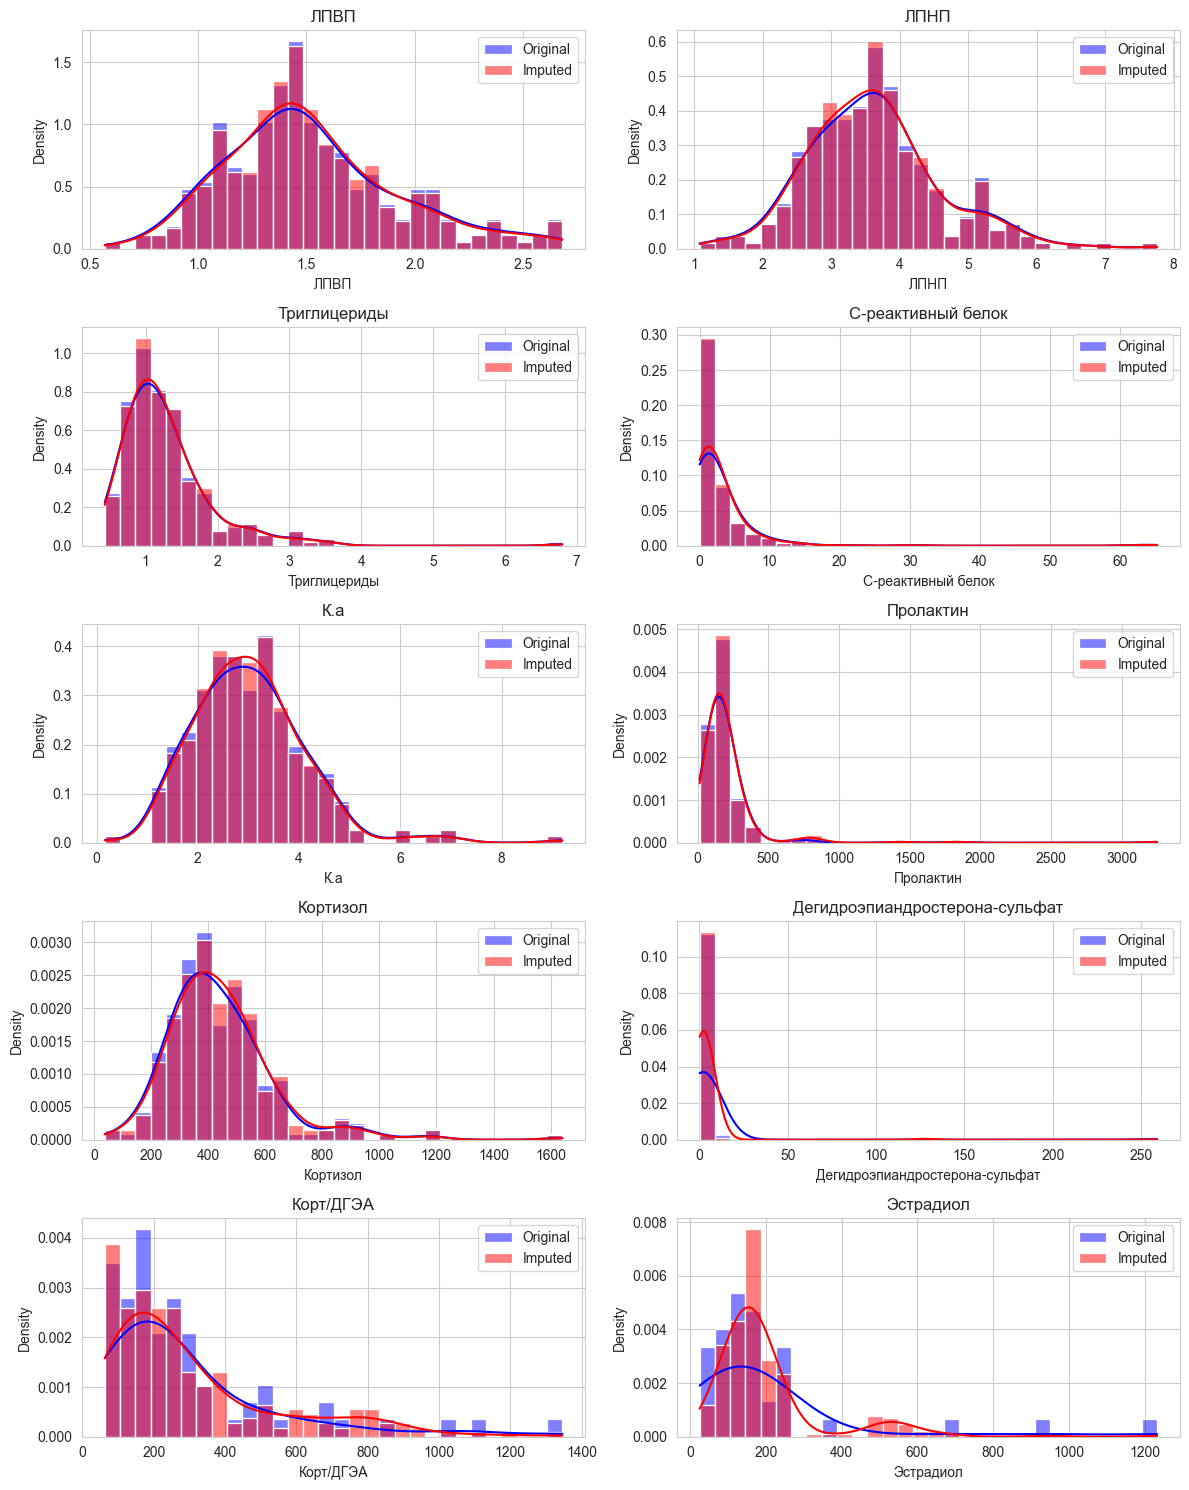

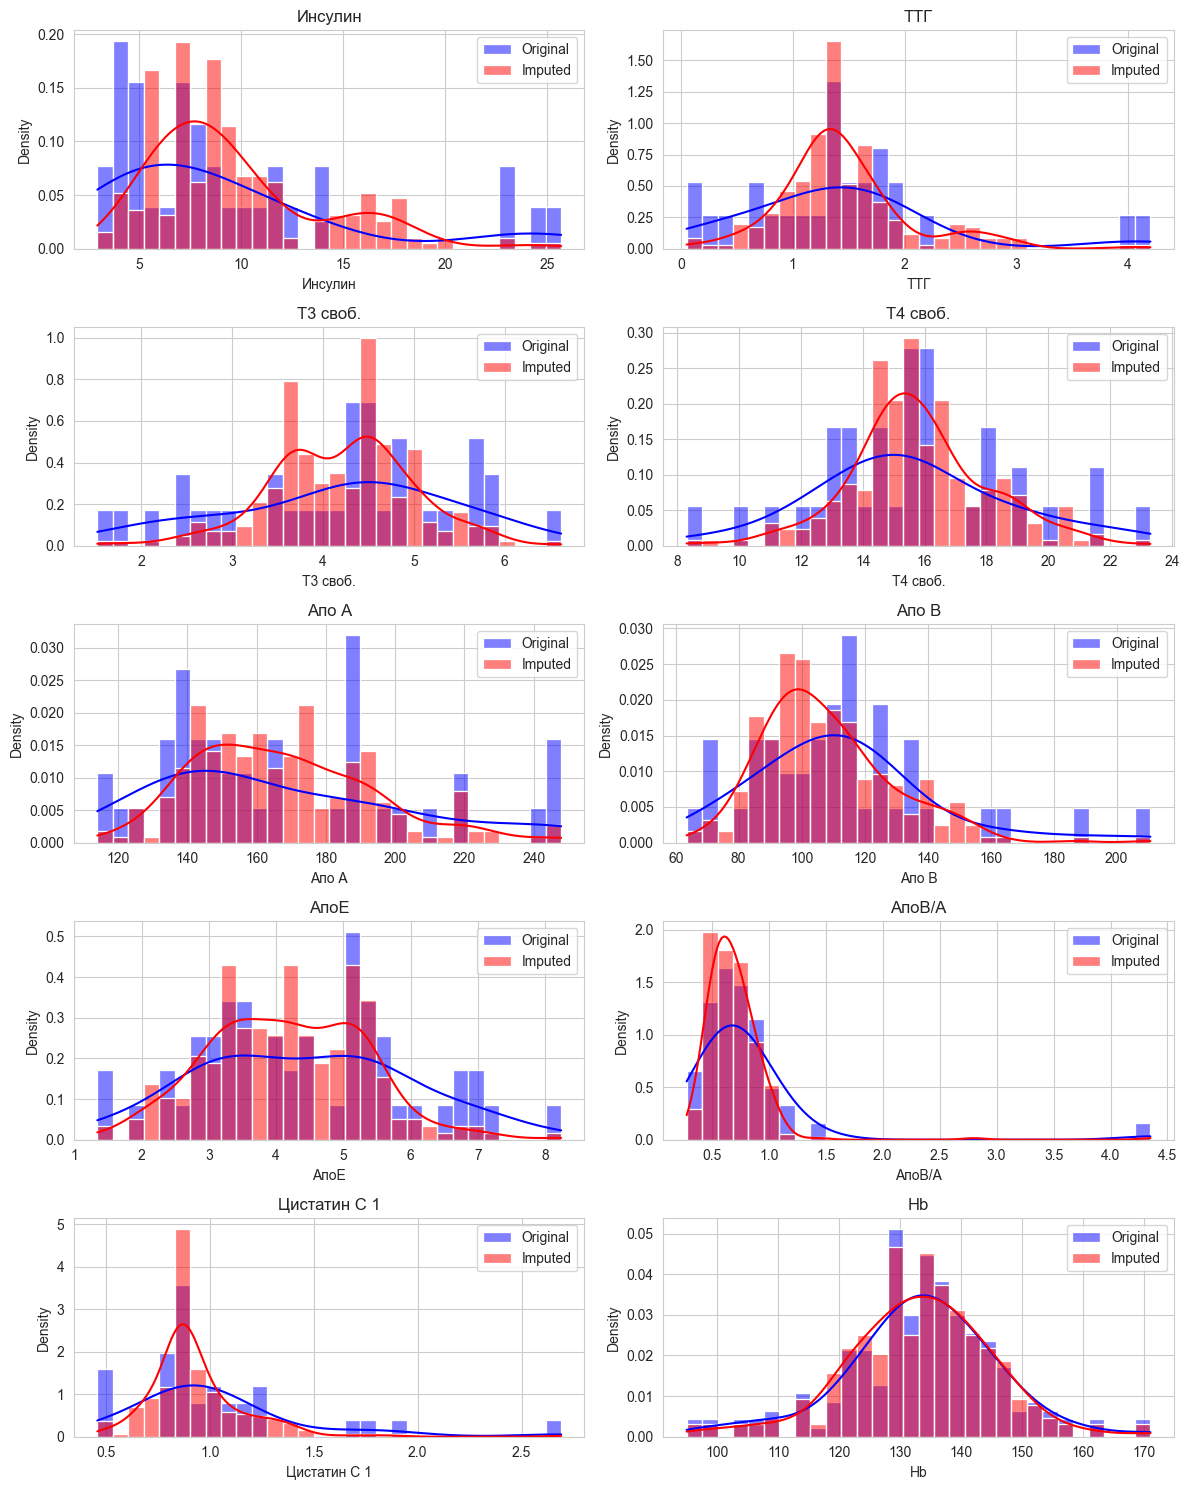

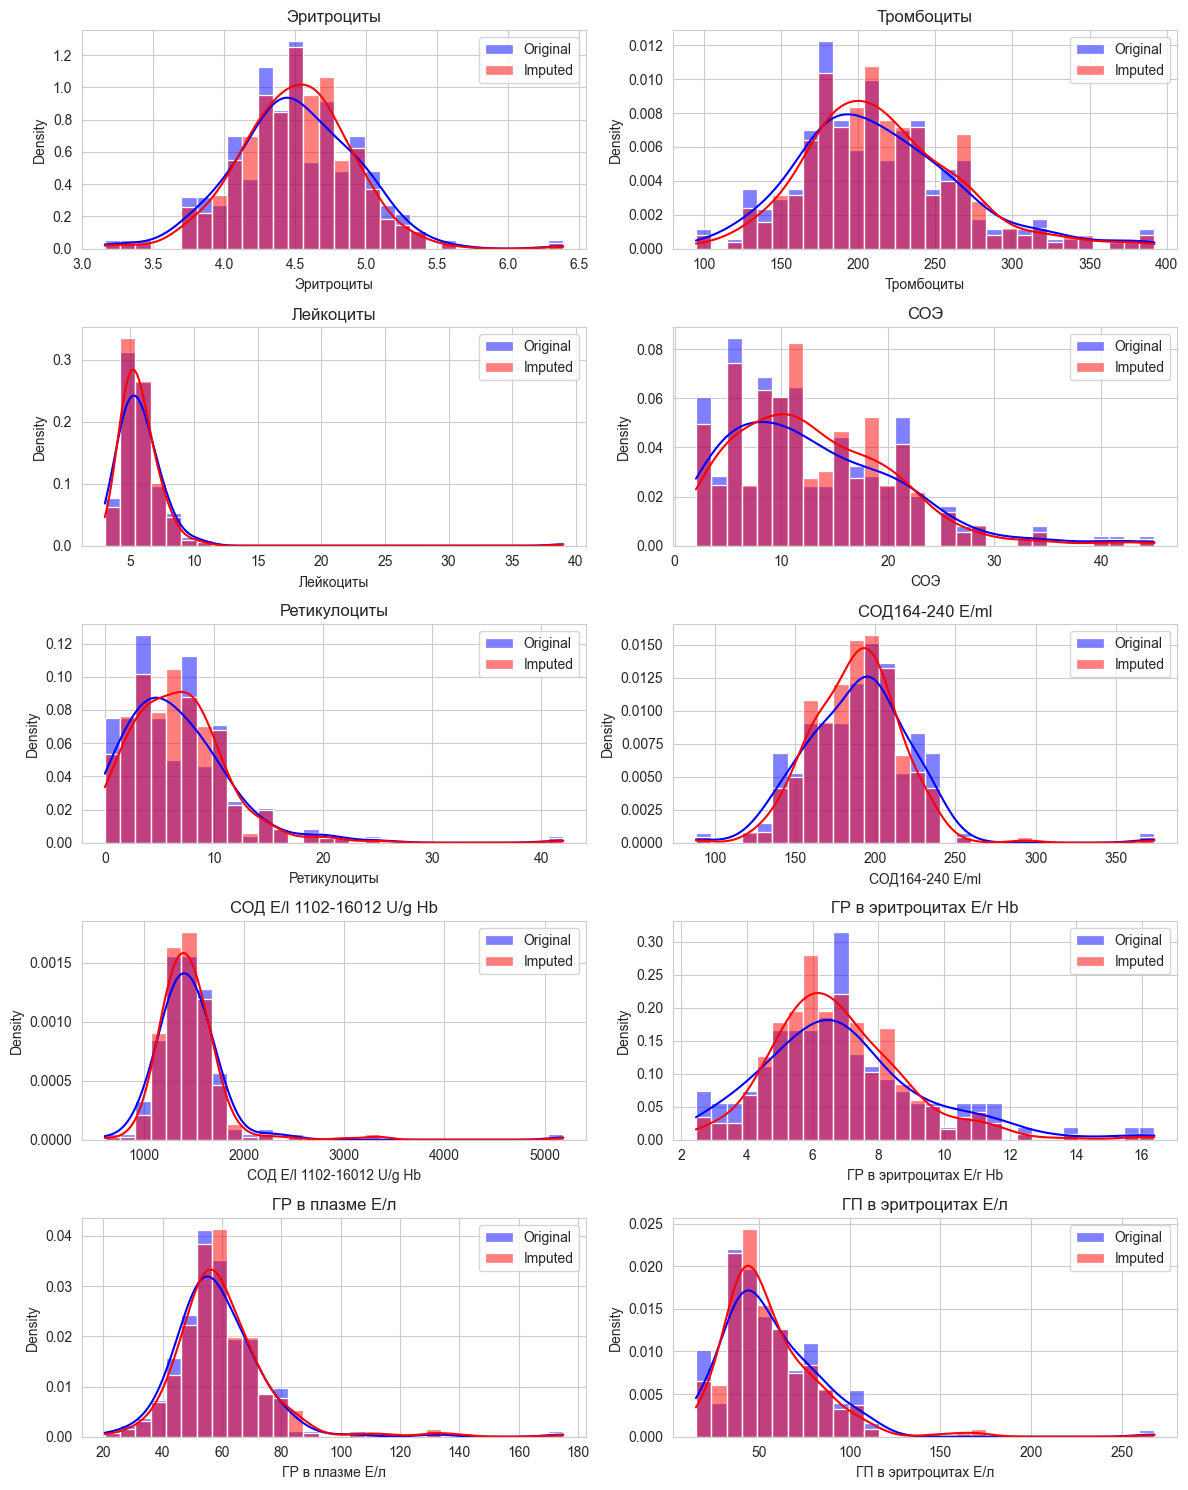

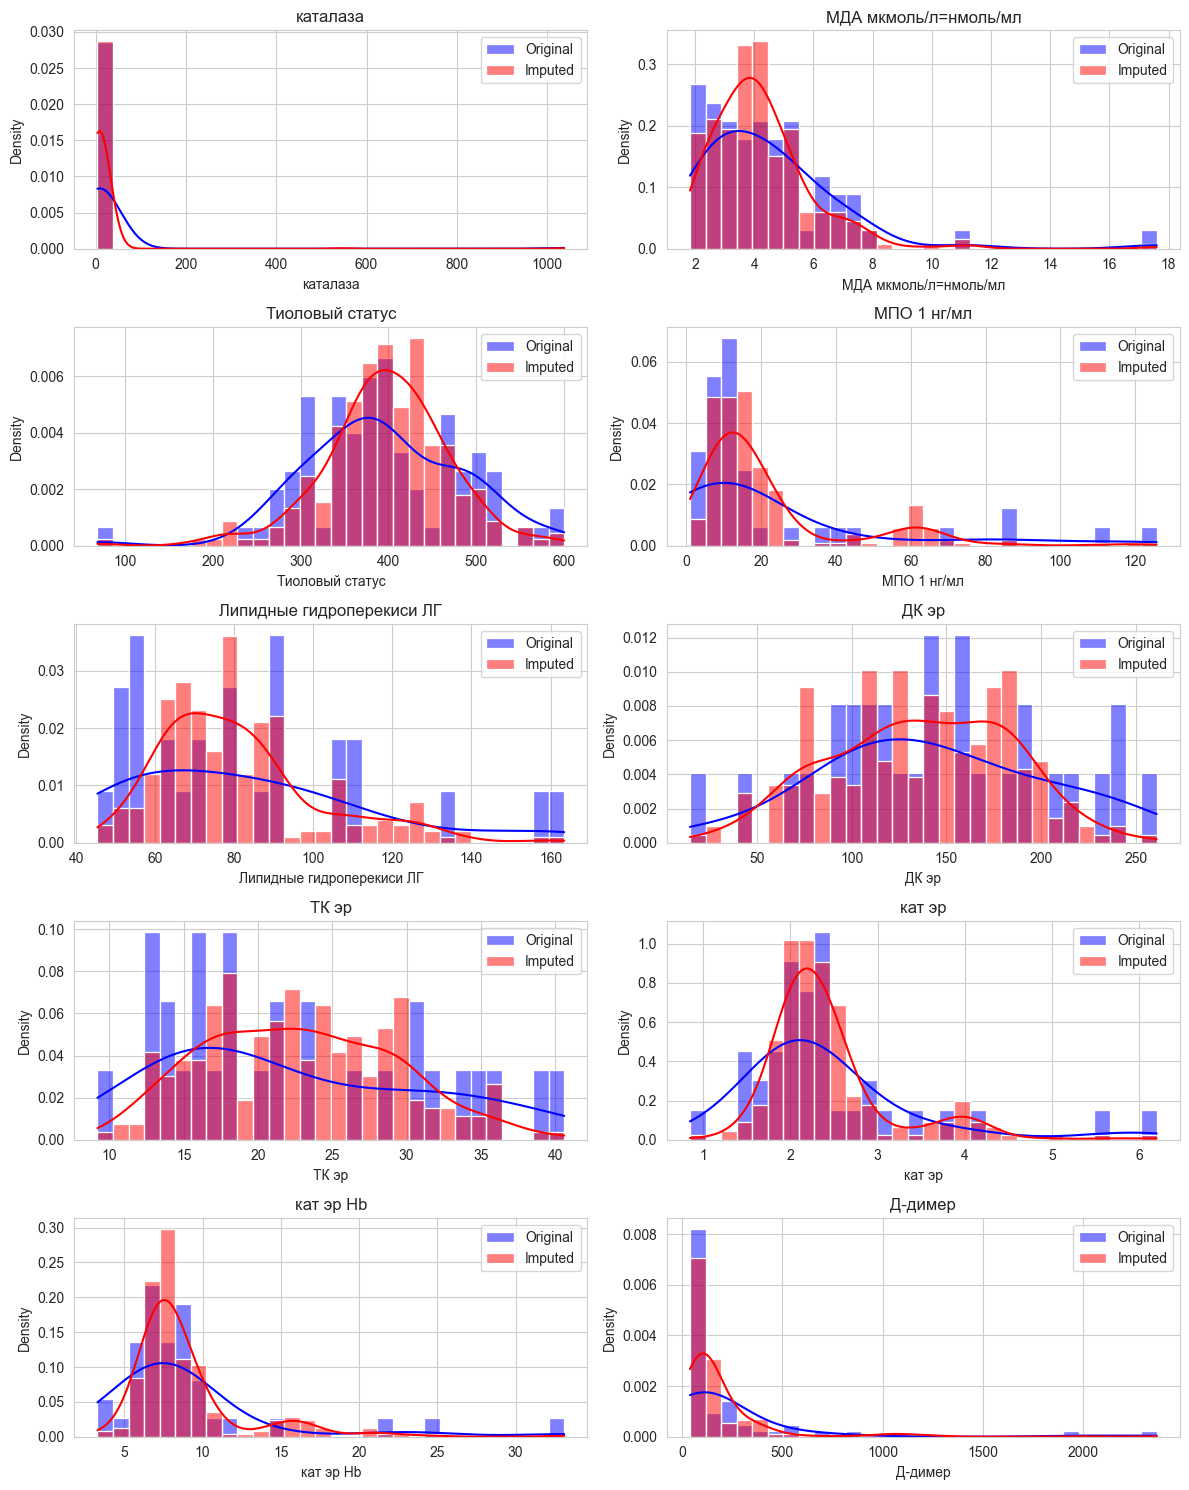

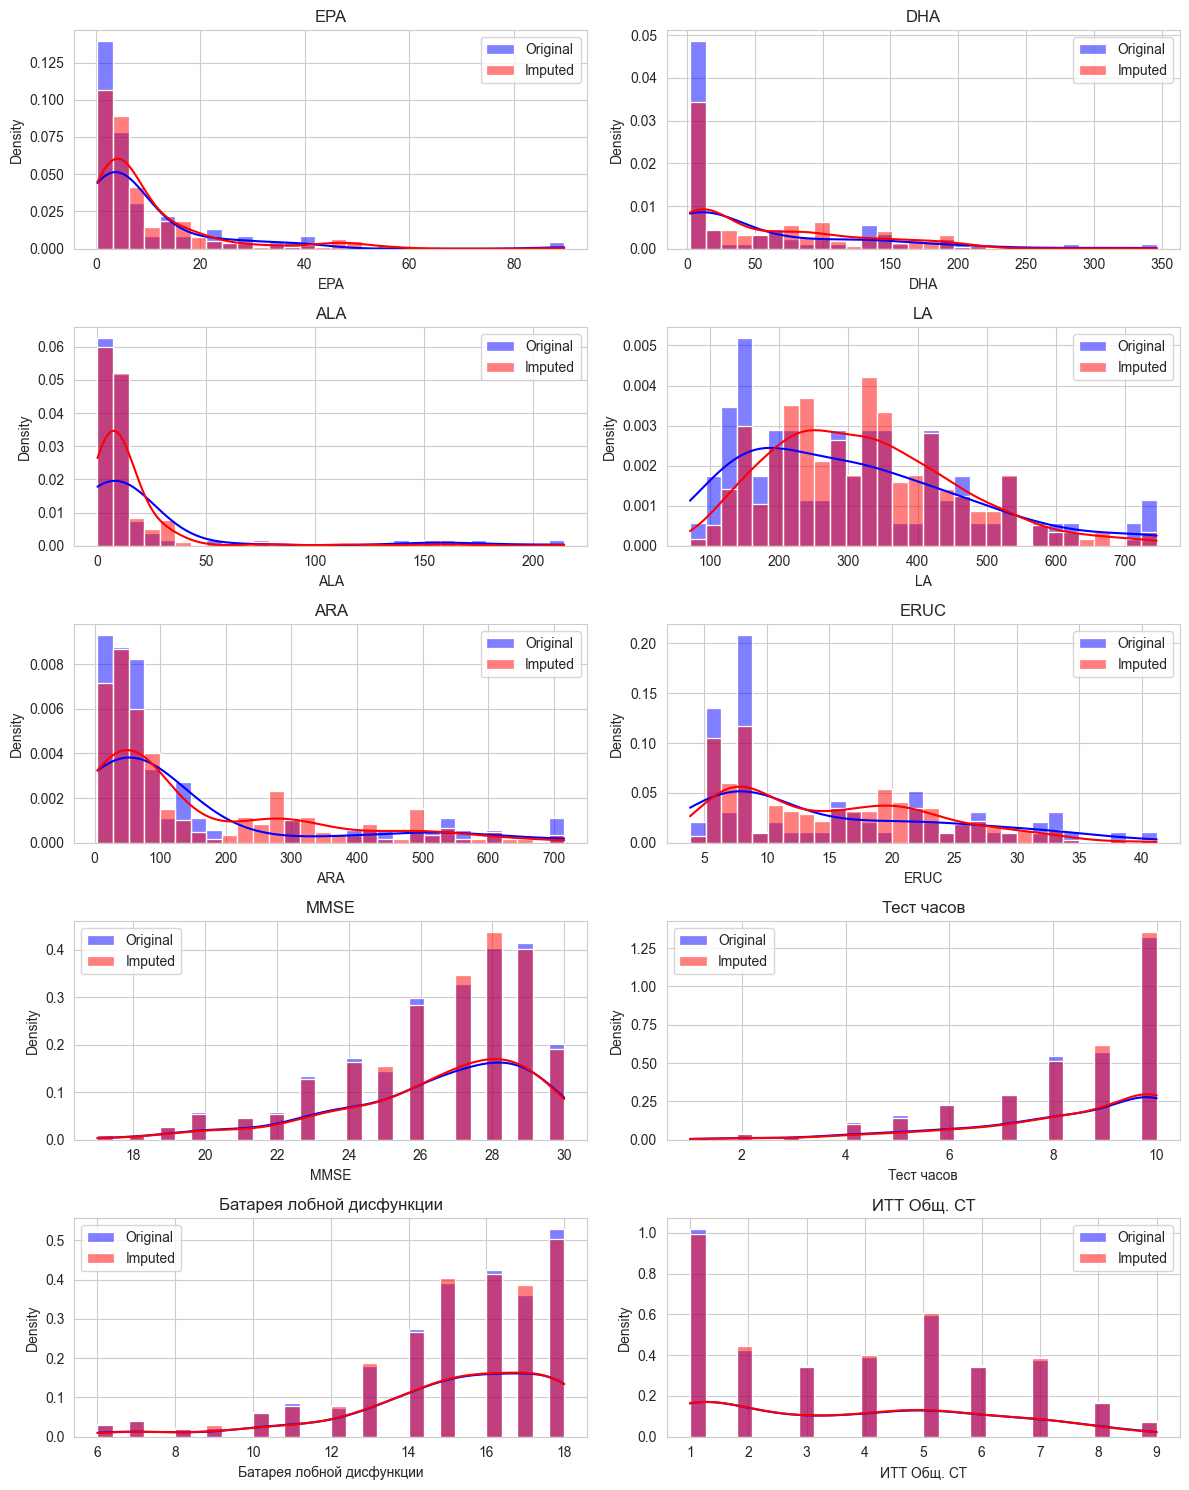

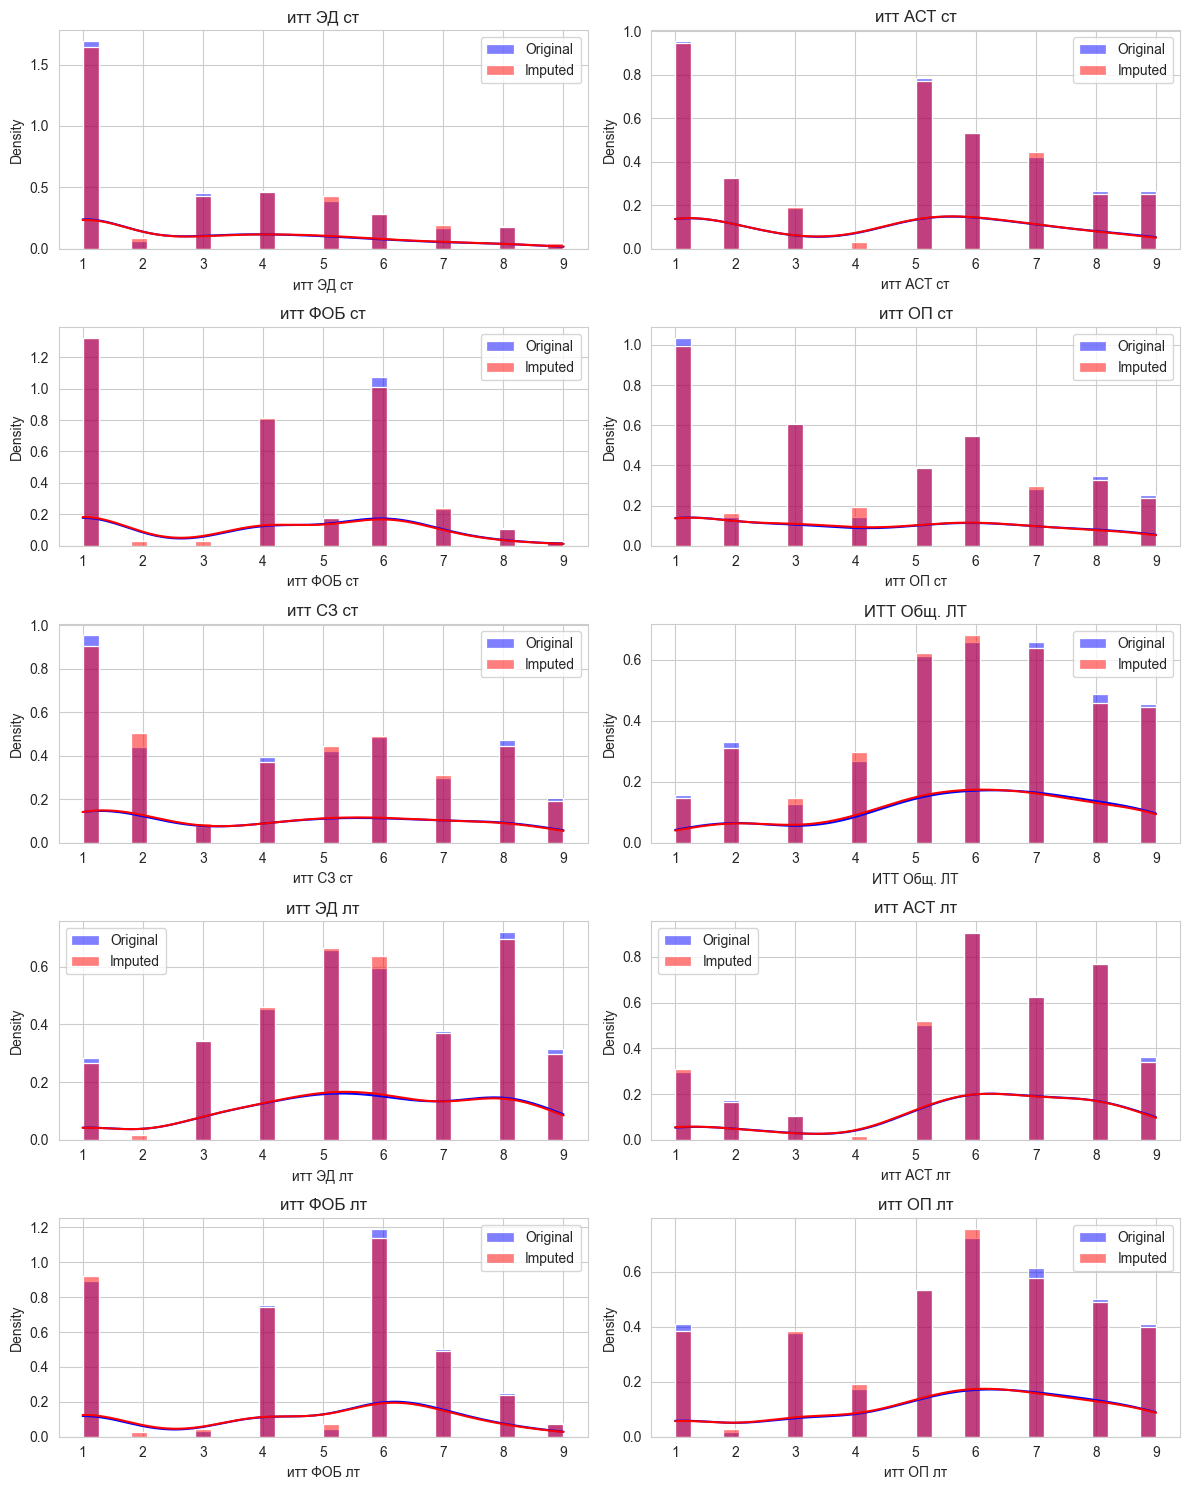

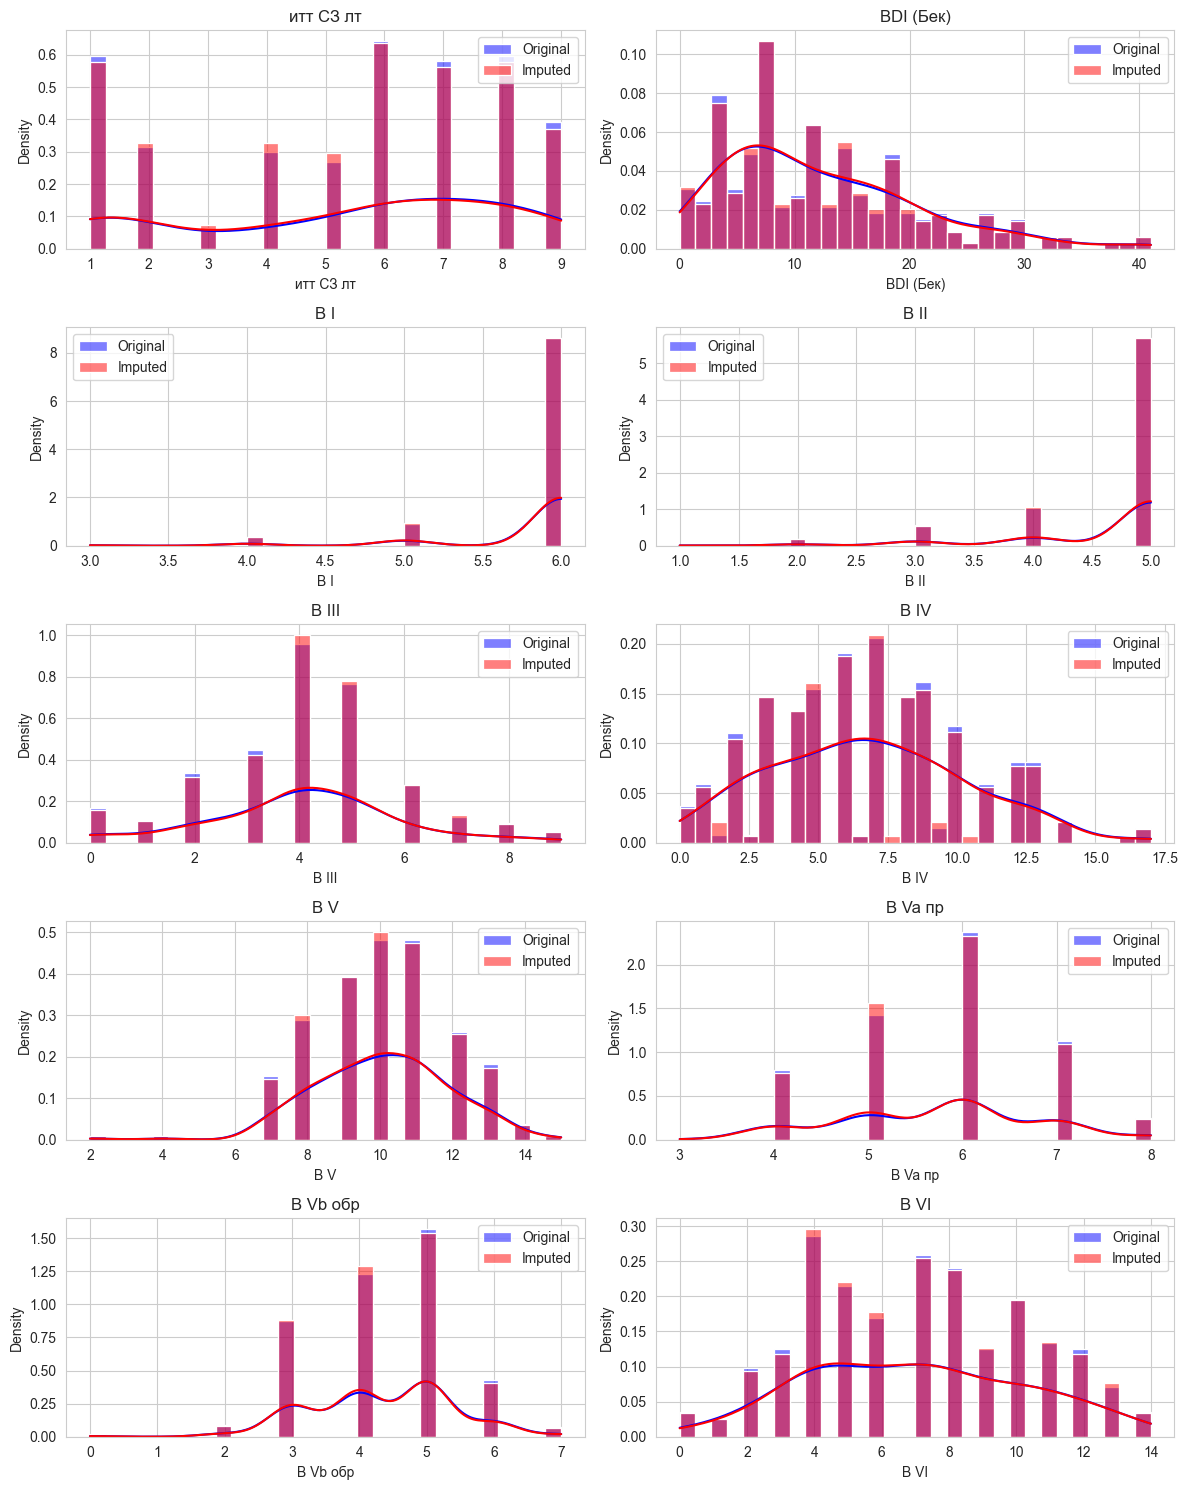

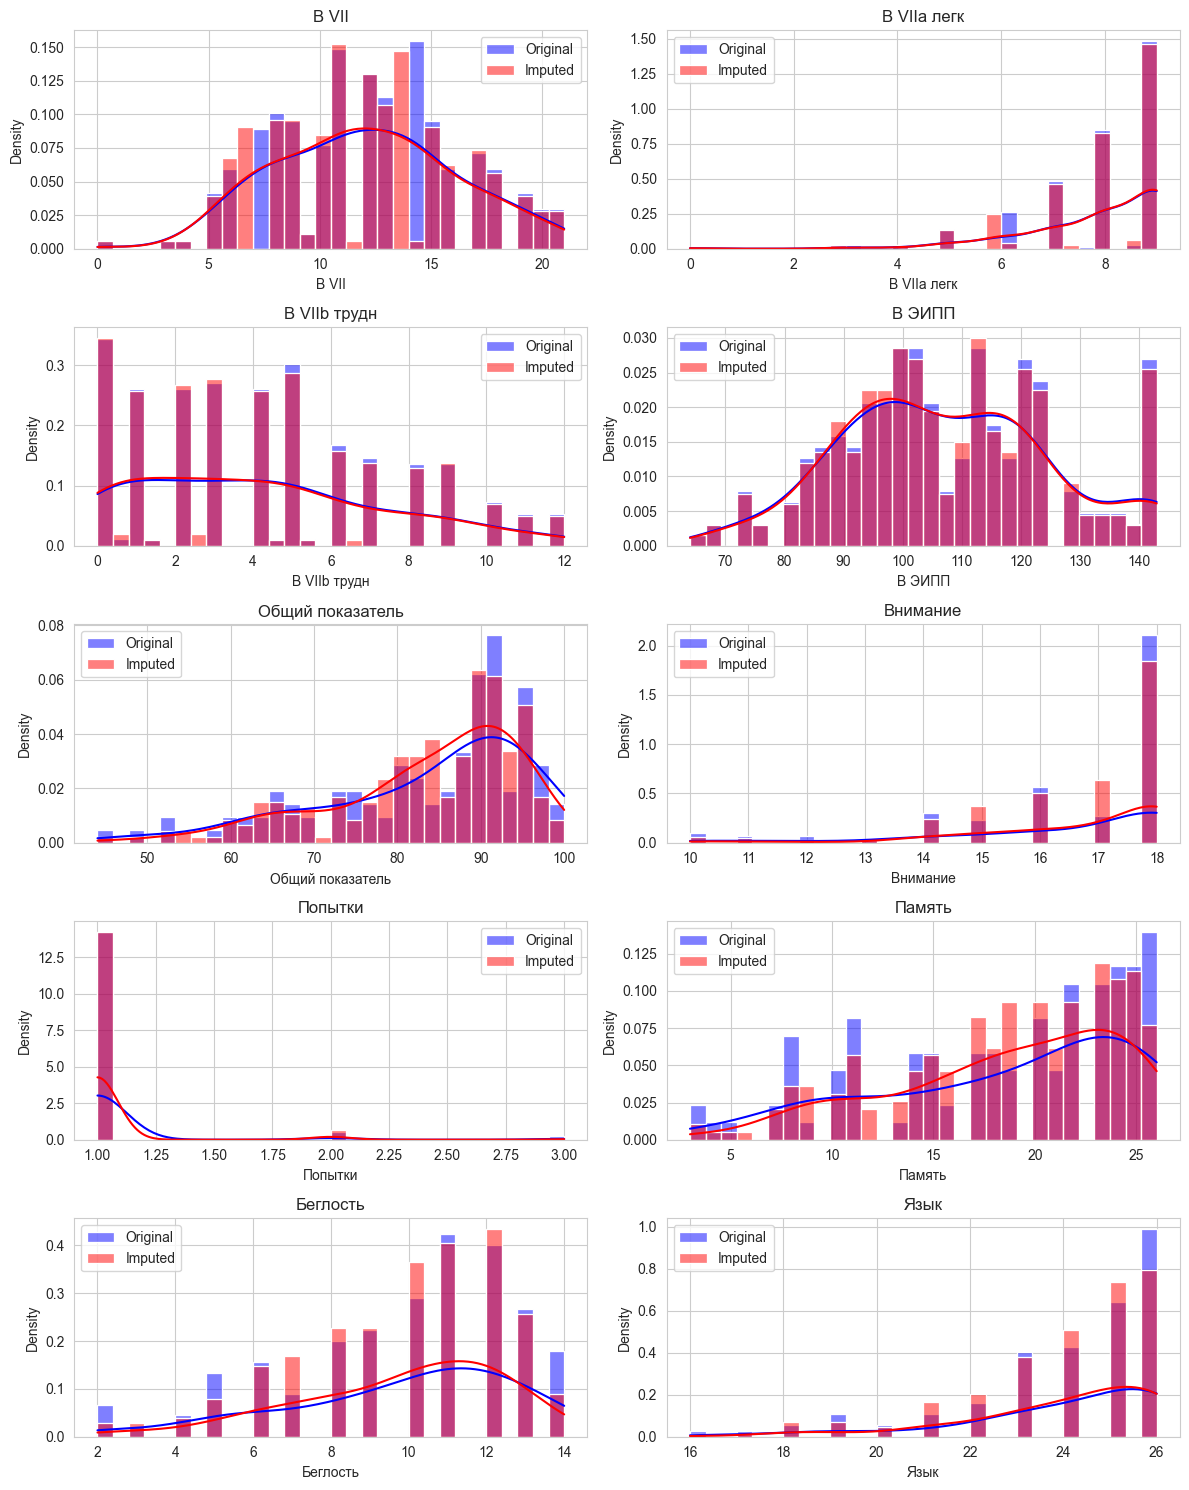

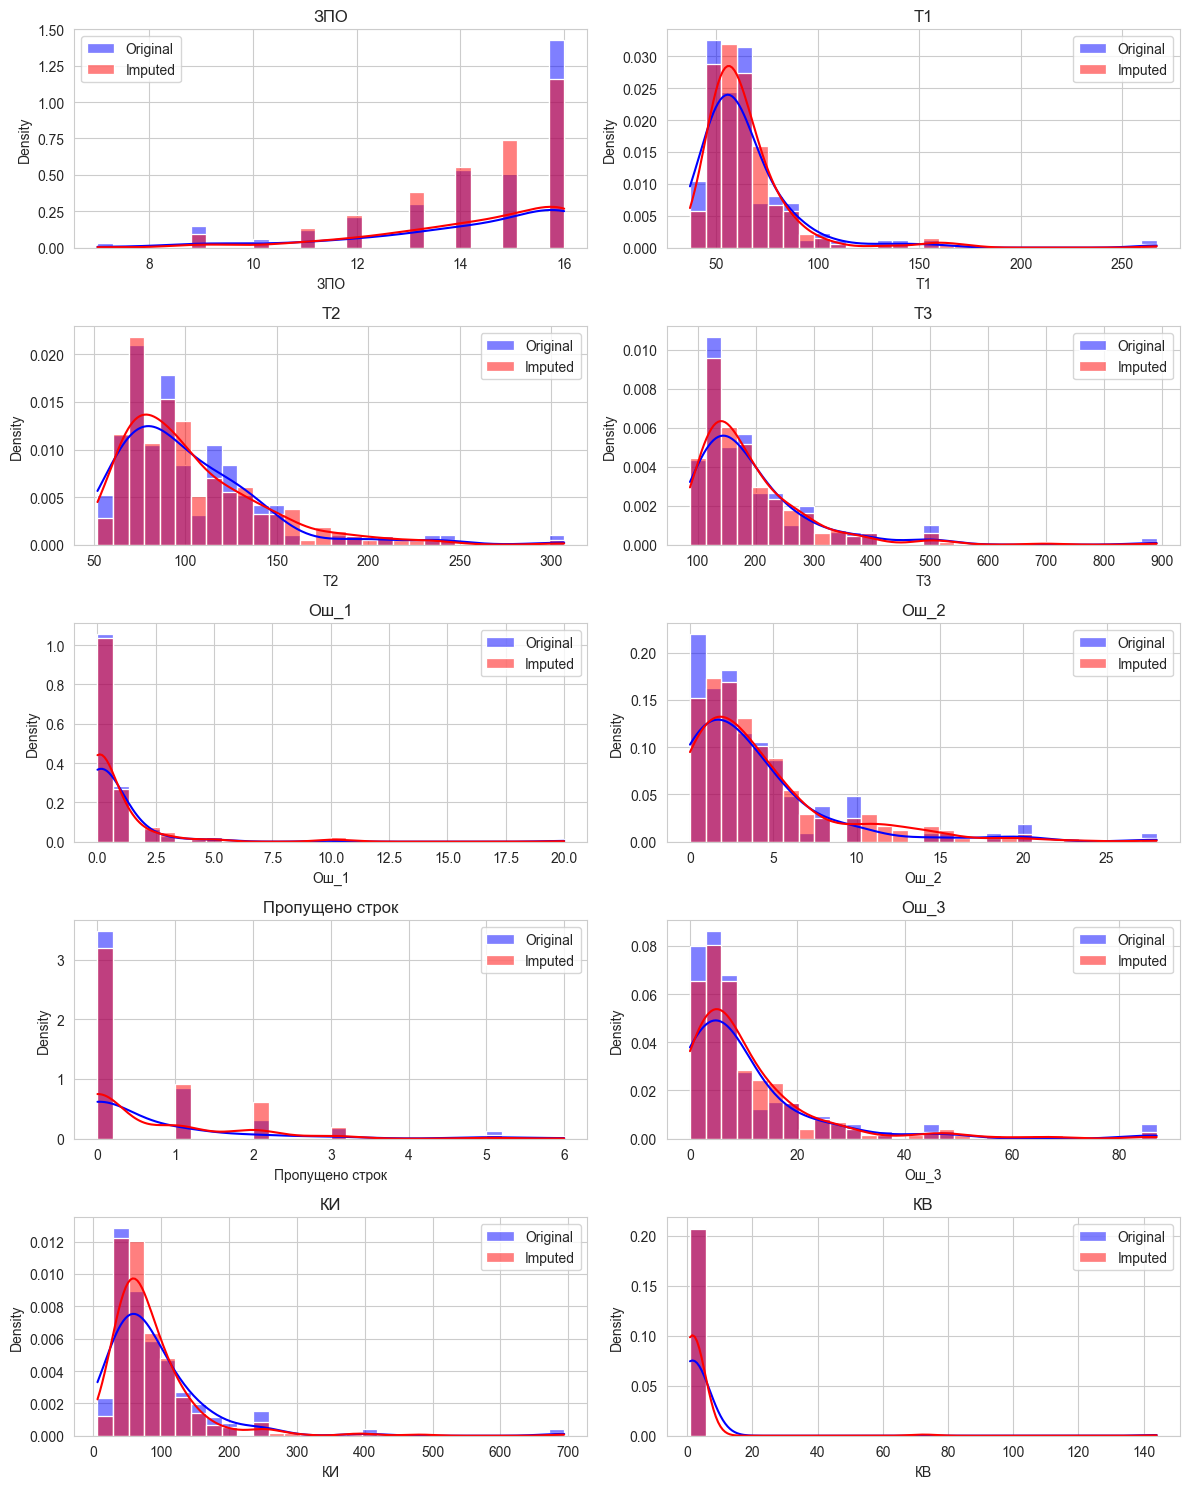

In [13]:
def plot_feature_distributions(original_df, imputed_df, exclude_columns, n_cols=2, n_rows=5):
    features = [col for col in original_df.columns if col not in exclude_columns]
    num_features = len(features)
    
    features_per_plot = 10
    num_plots = num_features // features_per_plot

    for i in range(num_plots):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 15))
        axes = axes.flatten()
        
        selected_features = features[i * features_per_plot:(i + 1) * features_per_plot]

        for j, col in enumerate(selected_features):
            ax = axes[j]

            sns.histplot(original_df[col].dropna(), kde=True, color='blue', label='Original', ax=ax, stat="density", bins=30)
            sns.histplot(imputed_df[col], kde=True, color='red', label='Imputed', ax=ax, stat="density", bins=30)

            ax.set_title(col)
            ax.legend()

        plt.tight_layout()
        plt.show()

imputed_df = all_imputed_dfs['KNNImputer (2 neigh, w=dist) (scaled)']
plot_feature_distributions(df_cleaned, imputed_df, ['Id', target_column])

In [14]:
imputed_df.head()

,Id,КОД3 основной,Пол,Образование,Трудовая деятельность,Семейное положение,Проживание,Жилищные условия,Инвалидность,Отягощ. Наследственность,Инфекционные болезни НС,Злоупотребление психоактивными вещ-вами,Интоксикации,ЧМТ,Гипертония,Церебрально-сосудистые нарушения,Эндокринные заболевания,"Аллергические заб., в т.ч. астма",операции,"Кол-во декомпенсаций (фаз, обострений)",Совпадение начала заболевания,Уровень выраженности псих. Расстр.,Левша,Возраст,Возраст дебюта расстройств (полных лет),Длительность заболевания (месяцев),Цитогенетика,Иммунология,Альбумин,Холестерин,Общий белок,Глюкоза,ЛПВП,ЛПНП,Триглицериды,С-реактивный белок,К.а,Пролактин,Кортизол,Дегидроэпиандростерона-сульфат,Корт/ДГЭА,Эстрадиол,Инсулин,ТТГ,Т3 своб.,Т4 своб.,Апо А,Апо В,АпоЕ,АпоВ/А,Цистатин С 1,Hb,Эритроциты,Тромбоциты,Лейкоциты,СОЭ,Ретикулоциты,СОД164-240 E/ml,СОД E/l 1102-16012 U/g Hb,ГР в эритроцитах Е/г Hb,ГР в плазме E/л,ГП в эритроцитах Е/л,каталаза,МДА мкмоль/л=нмоль/мл,Тиоловый статус,МПО 1 нг/мл,Липидные гидроперекиси ЛГ,ДК эр,ТК эр,кат эр,кат эр Hb,Д-димер,EPA,DHA,ALA,LA,ARA,ERUC,MMSE,Тест часов,Батарея лобной дисфункции,ИТТ Общ. СТ,итт ЭД ст,итт АСТ ст,итт ФОБ ст,итт ОП ст,итт СЗ ст,ИТТ Общ. ЛТ,итт ЭД лт,итт АСТ лт,итт ФОБ лт,итт ОП лт,итт СЗ лт,BDI (Бек),В I,В II,В III,В IV,В V,В Va пр,В Vb обр,В VI,В VII,В VIIa легк,В VIIb трудн,В ЭИПП,Общий показатель,Внимание,Попытки,Память,Беглость,Язык,ЗПО,T1,T2,T3,Ош_1,Ош_2,Пропущено строк,Ош_3,КИ,КВ
0,1,1.0,2,6,6,4,3,1,1,1,1,1,1,1,2,2,1.0,1,2,3,1,3,1,83,63,240,51,81,40.00,6.05,72.30,5.35,1.82,2.91,0.92,13.85,2.330000,183.000000,1641.0,0.88,775.588237,107.600000,7.600000,1.18,2.63,12.97,220.800000,104.700000,7.21,0.470000,1.06,127,4.190297,261,5.000000,12,8.493631,214.340773,1696.075446,8.681857,55.768895,40.552516,9.293819,3.944883,414.433249,15.433832,80.274655,189.0,36.4,3.10,8.292908,166.748395,3.492712,7.910332,16.648671,477.679250,31.459271,17.778598,29,10,14,2,1,5,1,2,5,4,4,5,1,3,7,5,5,5,3,8.0,11,6,5,4,13.0,9.0,4.0,112,80,16,1,16,12,21,15,69,155,265,0,15,2,24,79,2.281882
1,2,1.0,1,4,6,4,1,1,1,1,1,2,1,1,2,1,1.0,1,2,1,2,3,1,69,69,3,55,28,45.20,5.90,73.00,5.35,1.15,4.45,1.36,9.96,3.190802,117.402432,564.0,3.60,178.272922,244.600000,23.400000,1.40,4.50,18.10,181.670000,124.900000,4.12,0.700000,1.04,140,4.642355,226,6.270995,17,8.051185,177.187679,1270.908477,5.152847,59.851385,48.418537,6.838275,2.017043,399.328023,21.092468,61.502327,237.4,40.6,1.97,6.840000,330.181804,4.047614,94.962708,1.543509,501.555766,269.448195,22.917399,25,8,15,4,3,2,4,4,8,8,9,8,6,6,7,24,6,5,4,7.0,10,6,4,2,10.0,7.0,3.0,94,92,18,1,24,9,26,16,54,79,134,0,2,0,5,54,1.450217
2,3,3.0,2,6,6,4,1,1,1,1,1,1,1,1,2,1,3.0,1,2,1,2,2,1,64,63,7,45,44,43.98,6.96,71.98,3.90,2.09,3.68,1.23,0.20,3.122920,36.000000,516.0,1.80,895.190130,173.208464,12.000000,4.20,2.40,21.70,247.890000,112.570000,5.23,0.440000,0.93,123,4.233363,225,4.821239,23,8.013275,184.960176,1527.713192,7.113850,60.570882,54.376194,10.699890,3.554589,430.086731,57.480046,126.619916,231.2,39.5,1.48,5.920000,102.538647,5.596550,32.110251,6.386704,215.784944,87.348661,15.459068,27,10,18,4,1,5,1,6,6,7,7,6,1,9,8,19,6,5,6,11.0,11,6,5,11,21.0,9.0,12.0,143,90,17,1,23,13,26,12,55,104,177,0,4,0,2,74,1.882522
3,4,1.0,2,4,1,5,2,1,1,1,1,1,1,1,1,1,1.0,1,2,1,1,1,1,56,54,24,80,49,42.75,5.88,68.94,4.83,1.74,2.95,0.78,0.06,2.200000,95.000000,393.0,3.42,754.015039,157.400000,10.706971,1.45,5.17,19.20,199.603814,101.005827,6.14,0.513084,0.52,146,4.725302,197,3.934876,14,7.979835,191.919339,1316.029409,8.309349,86.223478,52.962902,9.236026,2.365888,430.262251,6.688370,115.690055,180.2,30.8,1.62,5.490000,325.905693,1.461269,8.138813,8.144724,250.589022,64.322895,14.781785,29,10,15,5,3,5,4,9,5,7,8,8,1,7,7,7,6,5,5,11.0,12,6,6,6,18.0,9.0,9.0,120,92,17,1,23,12,25,14,58,86,159,0,2,0,2,73,1.451487
4,5,2.0,1,4,6,2,3,1,1,1,1,1,1,1,1,2,1.0,1,2,1,1,3,1,74,73,12,67,40,41.13,4.42,68.26,5.77,0.81,2.46,1.69,1.02,3.010867,165.000000,503.0,2.06,293.762899,143.000000,11.600000,1.80,3.80,16.10,134.160000,87.880000,3

In [15]:
features = imputed_df.drop(columns=['Id', target_column])
target = imputed_df[target_column]
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(features[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index=features.index)
# umap_model = umap.UMAP(n_components=10, random_state=42)
# umap_result = umap_model.fit_transform(encoded_df)
# umap_df = pd.DataFrame(umap_result, columns=[f"UMAP_Component_{i+1}" for i in range(umap_result.shape[1])], index=encoded_df.index)
# features = pd.concat([features.drop(columns=cat_cols), umap_df], axis=1)
features = features.drop(columns=cat_cols)
scaler = StandardScaler()
scaled = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled, columns=features.columns, index=features.index)

# df_final = pd.concat([target, scaled_df], axis=1)
df_final = pd.concat([target, encoded_df, scaled_df], axis=1)
df_final[target_column] = df_final[target_column].round().astype('Int64')
df_final.head()

,КОД3 основной,Пол_1.0,Пол_2.0,Образование_2.0,Образование_3.0,Образование_4.0,Образование_5.0,Образование_6.0,Образование_7.0,Трудовая деятельность_1.0,Трудовая деятельность_2.0,Трудовая деятельность_3.0,Трудовая деятельность_4.0,Трудовая деятельность_5.0,Трудовая деятельность_6.0,Трудовая деятельность_7.0,Трудовая деятельность_8.0,Семейное положение_1.0,Семейное положение_2.0,Семейное положение_3.0,Семейное положение_4.0,Семейное положение_5.0,Проживание_1.0,Проживание_2.0,Проживание_3.0,Проживание_4.0,Жилищные условия_1.0,Жилищные условия_2.0,Жилищные условия_4.0,Инвалидность_1.0,Инвалидность_2.0,Инвалидность_3.0,Инвалидность_4.0,Отягощ. Наследственность_1.0,Отягощ. Наследственность_2.0,Инфекционные болезни НС_1.0,Инфекционные болезни НС_2.0,Злоупотребление психоактивными вещ-вами_1.0,Злоупотребление психоактивными вещ-вами_2.0,Злоупотребление психоактивными вещ-вами_4.0,Интоксикации_1.0,Интоксикации_2.0,ЧМТ_1.0,ЧМТ_2.0,Гипертония_1.0,Гипертония_2.0,Гипертония_3.0,Церебрально-сосудистые нарушения_1.0,Церебрально-сосудистые нарушения_2.0,"Аллергические заб., в т.ч. астма_1.0","Аллергические заб., в т.ч. астма_2.0",операции_1.0,операции_2.0,"Кол-во декомпенсаций (фаз, обострений)_0.0","Кол-во декомпенсаций (фаз, обострений)_1.0","Кол-во декомпенсаций (фаз, обострений)_2.0","Кол-во декомпенсаций (фаз, обострений)_3.0","Кол-во декомпенсаций (фаз, обострений)_4.0","Кол-во декомпенсаций (фаз, обострений)_5.0","Кол-во декомпенсаций (фаз, обострений)_7.0","Кол-во декомпенсаций (фаз, обострений)_10.0",Совпадение начала заболевания_0.0,Совпадение начала заболевания_1.0,Совпадение начала заболевания_2.0,Совпадение начала заболевания_3.0,Совпадение начала заболевания_4.0,Совпадение начала заболевания_5.0,Совпадение начала заболевания_6.0,Совпадение начала заболевания_7.0,Совпадение начала заболевания_8.0,Уровень выраженности псих. Расстр._1.0,Уровень выраженности псих. Расстр._2.0,Уровень выраженности псих. Расстр._3.0,Уровень выраженности псих. Расстр._4.0,Уровень выраженности псих. Расстр._5.0,Левша_1.0,Левша_2.0,Тест часов_1.0,Тест часов_2.0,Тест часов_3.0,Тест часов_4.0,Тест часов_5.0,Тест часов_6.0,Тест часов_7.0,Тест часов_8.0,Тест часов_9.0,Тест часов_10.0,ИТТ Общ. СТ_1.0,ИТТ Общ. СТ_2.0,ИТТ Общ. СТ_3.0,ИТТ Общ. СТ_4.0,ИТТ Общ. СТ_5.0,ИТТ Общ. СТ_6.0,ИТТ Общ. СТ_7.0,ИТТ Общ. СТ_8.0,ИТТ Общ. СТ_9.0,итт ЭД ст_1.0,итт ЭД ст_2.0,итт ЭД ст_3.0,итт ЭД ст_4.0,итт ЭД ст_5.0,итт ЭД ст_6.0,итт ЭД ст_7.0,итт ЭД ст_8.0,итт ЭД ст_9.0,итт АСТ ст_1.0,итт АСТ ст_2.0,итт АСТ ст_3.0,итт АСТ ст_4.0,итт АСТ ст_5.0,итт АСТ ст_6.0,итт АСТ ст_7.0,итт АСТ ст_8.0,итт АСТ ст_9.0,итт ФОБ ст_1.0,итт ФОБ ст_2.0,итт ФОБ ст_3.0,итт ФОБ ст_4.0,итт ФОБ ст_5.0,итт ФОБ ст_6.0,итт ФОБ ст_7.0,итт ФОБ ст_8.0,итт ФОБ ст_9.0,итт ОП ст_1.0,итт ОП ст_2.0,итт ОП ст_3.0,итт ОП ст_4.0,итт ОП ст_5.0,итт ОП ст_6.0,итт ОП ст_7.0,итт ОП ст_8.0,итт ОП ст_9.0,итт СЗ ст_1.0,итт СЗ ст_2.0,итт СЗ ст_3.0,итт СЗ ст_4.0,итт СЗ ст_5.0,итт СЗ ст_6.0,итт СЗ ст_7.0,итт СЗ ст_8.0,итт СЗ ст_9.0,ИТТ Общ. ЛТ_1.0,ИТТ Общ. ЛТ_2.0,ИТТ Общ. ЛТ_3.0,ИТТ Общ. ЛТ_4.0,ИТТ Общ. ЛТ_5.0,ИТТ Общ. ЛТ_6.0,ИТТ Общ. ЛТ_7.0,ИТТ Общ. ЛТ_8.0,ИТТ Общ. ЛТ_9.0,итт ЭД лт_1.0,итт ЭД лт_2.0,итт ЭД лт_3.0,итт ЭД лт_4.0,итт ЭД лт_5.0,итт ЭД лт_6.0,итт ЭД лт_7.0,итт ЭД лт_8.0,итт ЭД лт_9.0,итт АСТ лт_1.0,итт АСТ лт_2.0,итт АСТ лт_3.0,итт АСТ лт_4.0,итт АСТ лт_5.0,итт АСТ лт_6.0,итт АСТ лт_7.0,итт АСТ лт_8.0,итт АСТ лт_9.0,итт ФОБ лт_1.0,итт ФОБ лт_2.0,итт ФОБ лт_3.0,итт ФОБ лт_4.0,итт ФОБ лт_5.0,итт ФОБ лт_6.0,итт ФОБ лт_7.0,итт ФОБ лт_8.0,итт ФОБ лт_9.0,итт ОП лт_1.0,итт ОП лт_2.0,итт ОП лт_3.0,итт ОП лт_4.0,итт ОП лт_5.0,итт ОП лт_6.0,итт ОП лт_7.0,итт ОП лт_8.0,итт ОП лт_9.0,итт СЗ лт_1.0,итт СЗ лт_2.0,итт СЗ лт_3.0,итт СЗ лт_4.0,итт СЗ лт_5.0,итт СЗ лт_6.0,итт СЗ лт_7.0,итт СЗ лт_8.0,итт СЗ лт_9.0,В I_3.0,В I_4.0,В I_5.0,В I_6.0,В II_1.0,В II_2.0,В II_3.0,В II_4.0,В II_5.0,В III_0.0,В III_1.0,В III_2.0,В III_3.0,В III_4.0,В III_5.0,В III_6.0,В III_7.0,В III_8.0,В III_9.0,В Va пр_3.0,В Va пр_4.0,В Va пр_5.0,В Va пр_6.

In [16]:
df_final.to_csv("preprocessed/prepared_data_nonumap.csv", index=False)
# df_final.to_excel("preprocessed/prepared_data.xlsx", index=False)